<a href="https://colab.research.google.com/github/danon6868/blastim-ml/blob/main/ml_finetune_day_17/finetune_lecture_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
import json
from glob import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torchvision.transforms import Compose
from torch import nn
import os
import torch
import torchvision
import time

In [ ]:
import torch
import random
import numpy as np


torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(DEVICE)

cuda


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

clear_output()

In [ ]:
IMG_SIZE = 224, 224
BATCH_SIZE = 32

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 15, 10

In [ ]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "./hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ["train", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)
               for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

## Посмотрим на данные

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


def get_accuracy(model, dataloader, device):
    """
    model -
    dataloader -
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy


def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders["val"]):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis("off")
            ax.set_title("predicted: {}".format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

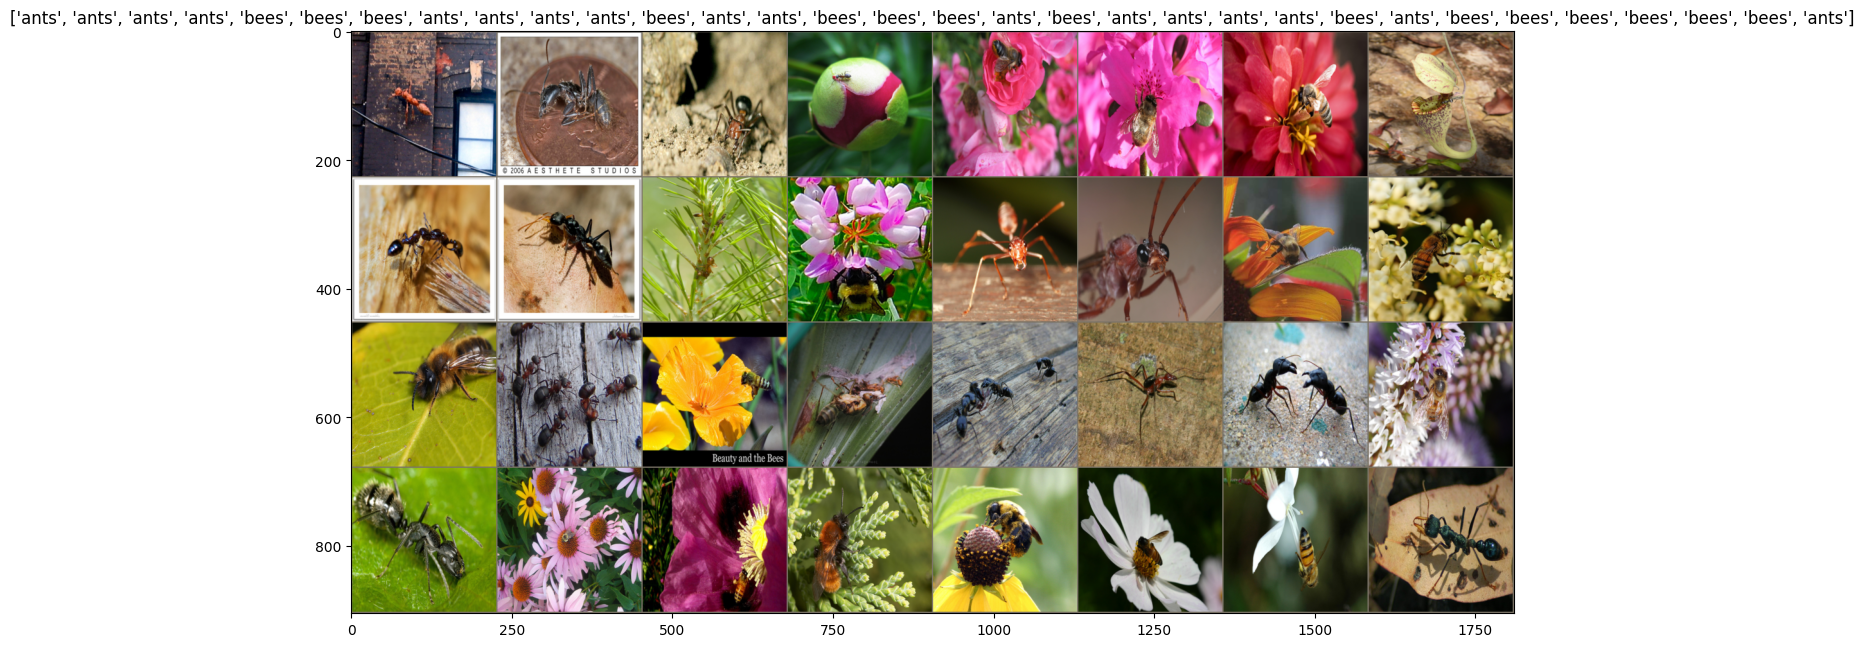

In [ ]:
# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders["train"]))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class_names

['ants', 'bees']

## Затухание градиента

Посмотрим на обычную сигмоиду

$$\sigma(z) = \dfrac 1 {1 + e^{-z}}$$

Ее производная равна

$$\dfrac {\delta \sigma(z)} {\delta z} = \sigma(z) (1 - \sigma(z))$$

Какое максимальное значение у такой функции?

Учтем, что сигмоида находится в пределах от 0 до 1

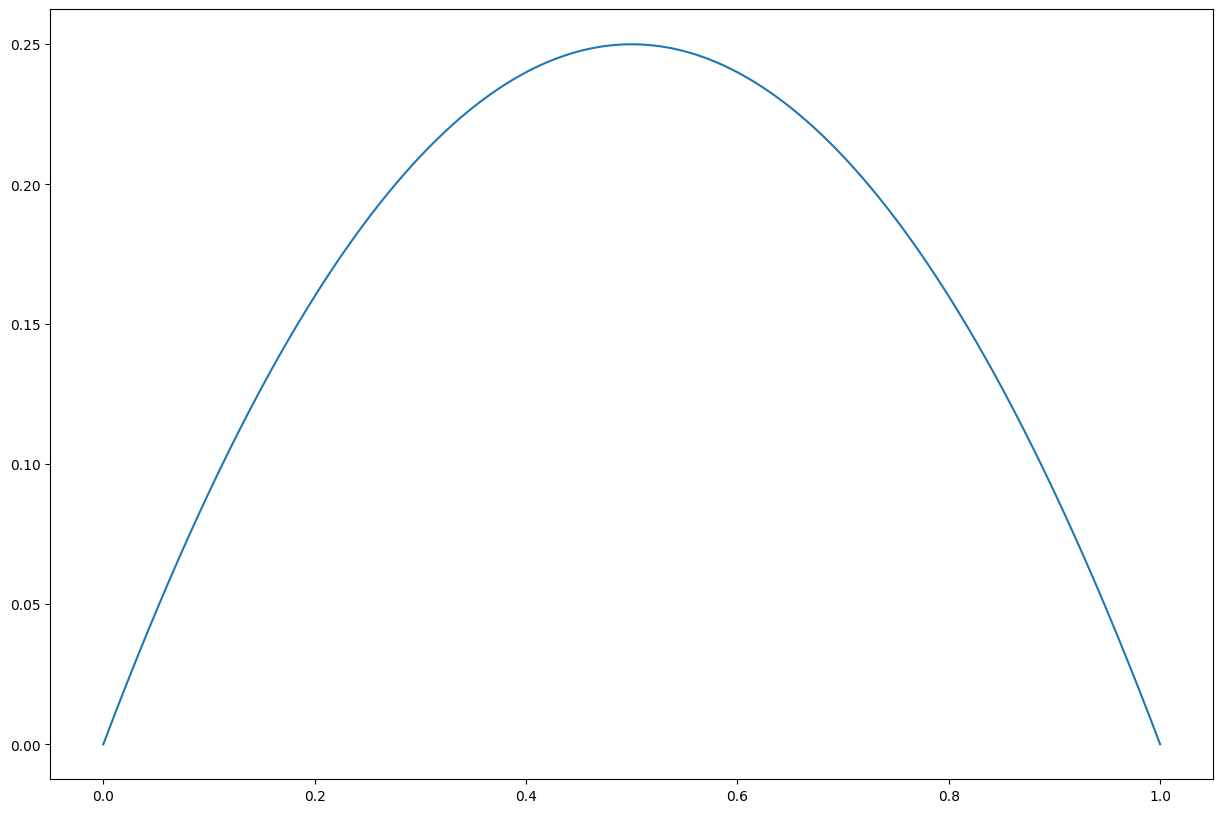

In [ ]:
x = np.arange(0, 1.001, 0.001)
plt.plot(x, x - x**2)
plt.show()

Получается, что максимальное значение производной по сигмоиде &ndash; $\frac{1}{4}$.

Теперь возьмем простую нейронную сеть:



Посчитаем у нее градиент

$$\dfrac {\delta L} {\delta z_4} = \dfrac {\delta L} {\delta y} \dfrac {\delta y} {\delta z_4} = \dfrac {\delta L} {\delta y} \dfrac {\delta \sigma(w_5z_4)} {\delta z_4}\le \dfrac 1 4 \dfrac {\delta L} {\delta y}  w_5 $$

Аналогично можно посчитать градиент для $z_3$

$$\dfrac {\delta L} {\delta z_3} = \dfrac {\delta L} {\delta z_4} \dfrac {\delta z_4} {\delta z_3} \le \dfrac {\delta L} {\delta y} \dfrac {\delta \sigma(w_4z)} {\delta z} w_5 \le {\dfrac 1 4}^2 \dfrac {\delta L} {\delta y}  w_5 w_4$$

И так далее

$$\dfrac {\delta L} {\delta x}  \le {\dfrac 1 4}^5 \dfrac {\delta L} {\delta y}  w_5 w_4 w_3 w_2 w_1$$

Таким образом, градиент начинает экспоненциально затухать, если веса маленькие.

Если веса большие - то градиент наоборот начнет экспоненциально возрастать - все взорвется

Для некоторых функций активации картина будет не столь катастрофична, но тоже неприятна.

Иногда с этим позволяет бороться выбор правильной **инициализации весов** для каждой функции активации

## Регуляризация

Второй способ улучшения сходимости нейросетей и борьбы с переобучением - введение регуляризации. Ее можно вводить несколькими способами.

### L1, L2 регуляризации

Самый простой способ - давайте просто добавим в лосс штраф к весам. На сходимость нейросети, это, правда, повлияет слабо.

$$Loss\_reg = loss + \lambda \cdot reg$$

$$ reg_{L1} = \lambda \sum |w_i| $$

$$ reg_{L2} = \lambda \sum w_i^2 $$

### Dropout

Одним из распространненных именно в нейросетях методом регуляризации является Dropout.

Состоит этот метод в следующем:

1. Во время обучения мы с вероятностью *p* зануляем выход нейронов слоя (например, *p* = 0.5)
2. Зануленные нейроны не участвуют в данном forward, и градиент потому к ним при backward не идет.

3. Сила регуляризации определяется вероятностью p, чем она больше - тем сильнее регуляризация.

## Мотивация Dropout

### Борьба с коадаптацией

Одной из  проблем при работе с глубокими сетями является совместная адаптация нейронов. В такой сети, если все весовые коэффициенты изучаются вместе, обычно некоторые соединения будут иметь больше возможностей прогнозирования, чем другие.

Часть нейронов делает основную работу - предсказывает, а остальные могут вообще не вносить никакого вклада в итоговое предсказание. Или же другая картина - один нейрон делает кривоватое предсказание, другие его правят и в итоге первый нейрон своей ошибки не исправляет.

Это явление называется со-адаптацией. Этого нельзя было предотвратить с помощью традиционной регуляризации, такой как L1 и L2. А вот Dropout с этим хорошо борется

### Dropout как ансамбль

Можно рассматривать Dropout как ансамбль нейросетей со схожими параметрами, которые мы учим одновременно, вместо того, чтобы учить каждую в отдельности, а затем результат их предсказания усредняем, замораживая Dropout (http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)

Фактически, возникает аналогия со случайным лесом - каждая из наших нейросетей легко выучивает выборку и переобучается - имеет низкий bias, но высокий variance. При этом за счет временного отключения активаций, каждая нейросеть видит не все объекты, а только часть. Усредняя все эти предсказания, мы уменьшаем variance.

### Confidence interval от Dropout
Можно используя нейросеть с дропаутом, получить доверительный интервал для вашего предсказания. Просто не "замораживаем" dropout-слои во время предсказания, а делаем предсказания с активными dropout.

И делаем forward через такую нейросеть для одного объекта 1000 раз.
Сделав это 1000 раз вы получаете распределение предсказаний, на основе которого можно делать confidence интервалы и как раз ловить те объекты, на которых нейросетей вообще не понимает, что ей делать и потому предсказывает метку или еще что-то с сильной дисперсией.

In [ ]:
do = nn.Dropout(p=0.9)
do(torch.tensor([1., 1., 10., 1., 1., 1, 1., 1., 1., 1., 1., 1]))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Нормализация

### Нормализация входных данных

Представим себе, что данные, которые мы подаем в нейросеть, распределены следующщим образом:

Фактически нейросети работают со скалярными произведениями. В этом плане две вектора, изображенных на рисунке, не сильно отличаются. Так же и точки нашего датасета слабо разделимы. Чтобы с этим работать, нейросеть сначала должна подобрать удобное преобразование, а затем только сравнивать наши объекты. Понятно, это усложняют задачу.

Для того, чтобы облегчить нейросети задачу, входные признаки часто нормируют:

$$x1' = \dfrac {x1 - \mu_{x1}} {\sigma_{x1}}$$
$$x2' = \dfrac {x2 - \mu_{x2}} {\sigma_{x2}}$$

Такое преобразование действительно помогает нейросети:

Но у нас может возникнуть ситуация, что выходы нейронов внутренних слоев уже не нормированы, получается поступающие признаки на входы нейронов следующих слоев уже не будут иметь определенное среднее и дисперсию, что как будто не совсем честно по отношению к скрытым слоям.

### Плохой вариант борьбы с этим

Давайте на каждом слое просто нормировать каждый признак, используя среднее и дисперсию по батчу

$$\tilde{x}_i^j = \dfrac {x_i^j - Ex^j} {\sqrt{Dx^j}}$$

Проблема в том, что таким образом мы можем попасть в область линейной составляющей нашей функции. Например, в случае сигмоиды

Получаем набор линейных слоев фактически без функций активации -> все вырождается в однослойную сеть. Не то что нам надо.

### BatchNormalization

Нам надо дать сети возможность перемещать распределение слоя из области 0 и самой подбирать дисперсию.

Сначала:

$$\tilde{x}_i^j = \dfrac {x_i^j - Ex^j} {\sqrt{Dx^j}}$$

Потом:

$$\hat{x_i^j} = \gamma^j\tilde{x}_i^j + \beta^j$$

$\gamma^j \ и \ \beta^j$ &ndash; обучаемые параметры!

Во время работы батчей у нас может не быть (например, 1 тестовый пример), тогда мы запомним среднее и дисперсию для обучающей выборки.

### Tips

Стоит помнить, что с батч-нормализацией:

* **Крайне важно** перемешивать объекты (составлять новые батчи) между эпохами. Единицей обучения параметров $\beta$ и $\gamma$ являются батчи. Если их не перемешивать, то из 6400 объектов в тренировочном датасете получим лишь 100 объектов для обучения $\beta$ и $\gamma$

* В слое, после которого поставили BatchNormalization, надо убрать смещения (параметр $\beta$ в BatchNormalization берет эту роль сам по себе)

* Если используем BatchNormalization, то надо уменьшить силу Dropout и L2-регуляризации

* Чем меньше размер батча в обучении, тем хуже будет работать BatchNormalization

## Больше данных это тоже регуляризация?

В случае картинок нам поможет аугментация данных. Мы понимаем, что кот может смотреть не только направо, но и налево, получается, что мы можем просто отразить картинку и получить уже новый объект для обучения. Различные аугментации лежат в `torchvision.transforms`. Обычно хорошей практикой является добавление их прямо в метод `__getitem__` вашего датасета. Тогда эти аугментации будут применять при попытке получить картинку. Но что делать, если вы не хотите всегда поворачивать кошку? Можно делать это с заданной вероятностью, и все...

[Примеры](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

In [ ]:
perspective_transformer = transforms.RandomPerspective(distortion_scale=0.6, p=1.0)

In [ ]:
orig_img = Image.open("/content/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg")
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
perspective_imgs = [orig_img] + perspective_imgs

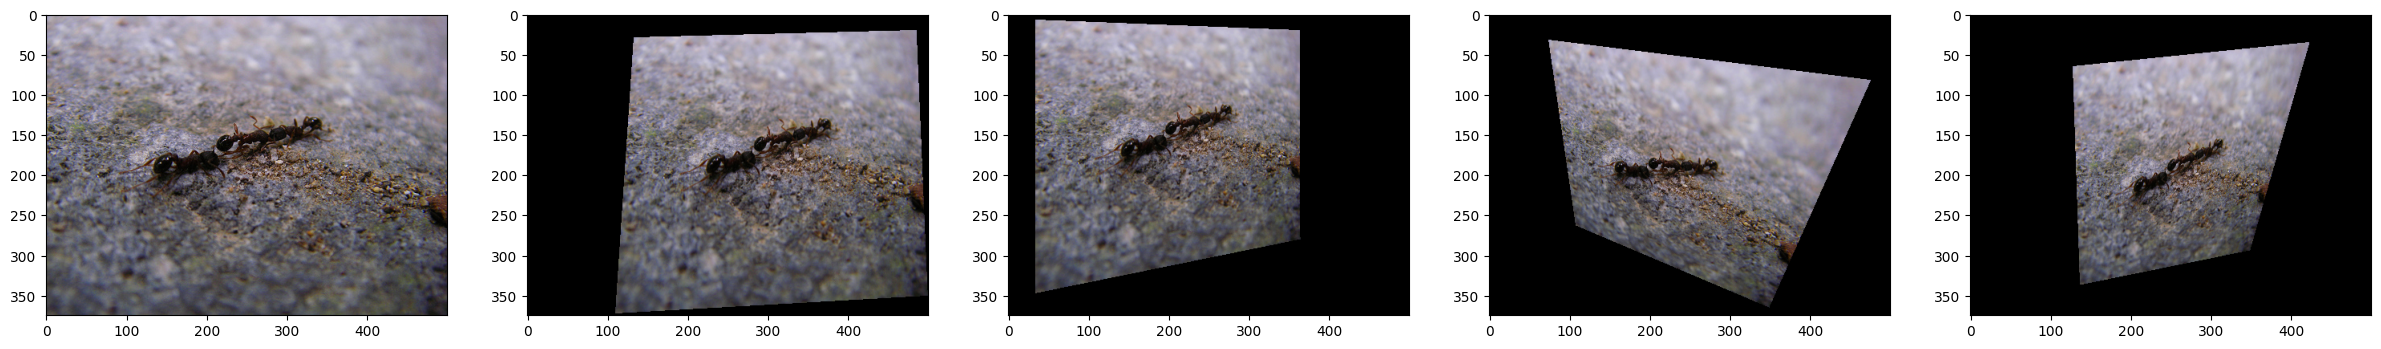

In [ ]:
_, axes = plt.subplots(1, 5, figsize=(30, 40))
axes = axes.ravel()

for i in range(5):
    axes[i].imshow(np.array(perspective_imgs[i]))

plt.show()

### Важно!!!

Не стоит делать аугментации тестовых (или валидационных данных), только тренировочные.

In [ ]:
# Пример (ЭТО ПСЕВДОКОД, он не должен работать, просто пример для разных трансформаций в зав от части данных)
class MyDataset(Dataset):
    def __init__(self, data_path=".",
                 train_transforms="Several train transforms",
                 test_transforms="Several test transforms",
                 mode="train"):
        super().__init__()

        self.data_path = data_path
        self.files = os.listdir(data_path)
        self.train_transforms = train_transforms
        self.test_transforms = test_transforms
        self.mode = mode

    def __getitem__(self, idx):
        im = Image.open(self.files[idx])
        label = self.files[idx][3]

        if self.mode == "train":
            im = self.train_transforms(im)
        else:
            im = self.test_transforms(im)

        return im, label

## Наконец, используем обученные модели (Fine tunning)

### Очередной раз новая функция для обучения модели

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {"train": [], "val": []}

    for epoch in range(num_epochs):
        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == "train":
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            losses[phase].append(epoch_loss)

            print(f"Phase: {phase}, Loss: {epoch_loss}, Accuracy: {epoch_acc}, Epoch: {epoch+1}/{num_epochs}")


            # если достиглось лучшее качество, то запомним веса модели
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        clear_output(wait=True)


    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 88.0MB/s]


<center><img src ="http://edunet.kea.su/repo/src/L09_CNN_Architectures/img_license/l09_6.png"  width="400" rotate="180"></center>
<center><em>Сравнение архитектур сетей AlexNet, VGG16 (использует 16 слоев) и VGG19 (использует 19 слоев).</em></center>

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Интересно узнать, сколько у нас параметров модели, и сколько она весит:

In [ ]:
! nvidia-smi

Thu Oct  5 11:05:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Возникает проблема

У нас классов меньше чем на ImageNet, нужно поменять последний слой. Давайте так и сделаем, а потом обучим полученную модель:

In [ ]:
num_features = 25088
model.classifier = nn.Linear(num_features, 2)
model = model.to(DEVICE)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, num_epochs=5)

Phase: train, Loss: 0.00019571849824402666, Accuracy: 1.0, Epoch: 5/5
Phase: val, Loss: 0.008111980421091217, Accuracy: 0.9150326797385621, Epoch: 5/5


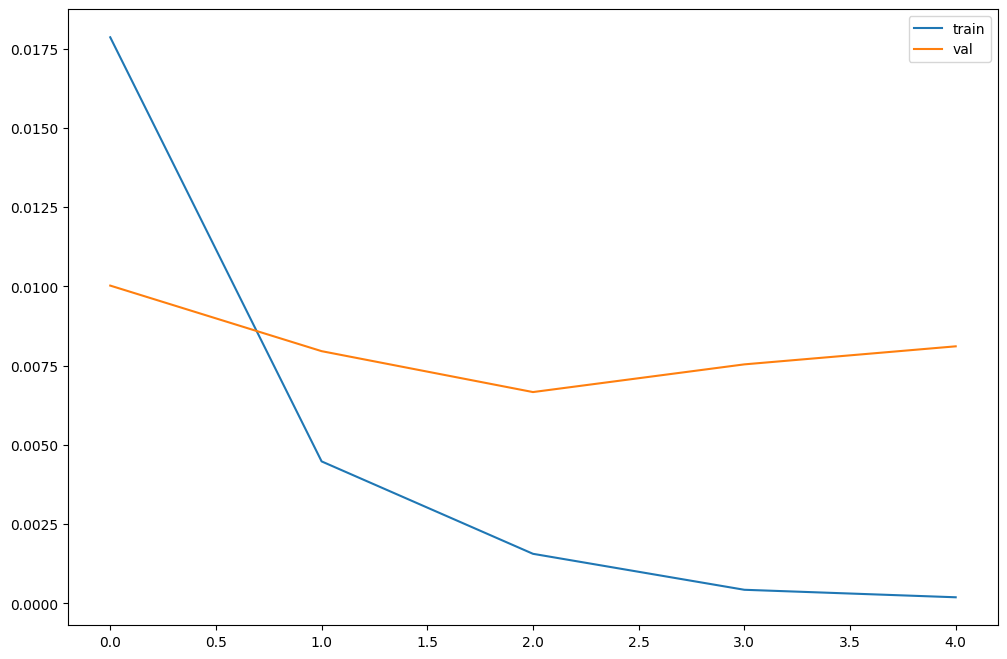

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.plot(losses["train"], label="train")
plt.plot(losses["val"], label="val")
plt.legend()
plt.show()

In [ ]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-3.2130e-08, -3.1717e-08, -6.7120e-08],
                        [-2.9321e-08, -2.1596e-08, -5.3207e-08],
                        [-5.3304e-08, -4.0832e-08, -6.6434e-08]],
              
                       [[ 1.3710e-07,  1.2848e-07,  7.1270e-08],
                        [ 1.5487e-07,  1.5186e-07,  8.3582e-08],
                        [ 9.3392e-08,  9.9451e-08,  4.1284e-08]],
              
                       [[ 1.7435e-07,  1.7840e-07,  1.0561e-07],
                        [ 1.9644e-07,  1.9769e-07,  1.2560e-07],
                        [ 1.1935e-07,  1.3447e-07,  5.9638e-08]]],
              
              
                      [[[-6.3467e-08, -5.2714e-08, -3.8511e-08],
                        [-1.4349e-08, -9.0426e-09, -1.7164e-08],
                        [ 2.2282e-08,  1.9084e-08,  1.8150e-09]],
              
                       [[-1.2191e-08, -6.1933e-09,  8.5022e-09],
                        [ 3.8618e-08,  5

In [ ]:
torch.save(model.state_dict(), "VGG19_fine_tune.pth")

Мы сейчас по сути обучали всю модель, но начинали для всех частей сети, кроме новодобавленного слоя, не со случайных весов, а с тех, которые получились при обучении на ImageNet. Это конечно круто, но та часть модели, которую мы только что добавили, может слегка испортить нам уже обученную часть просто из-за того, что ее параметры изначально являются случайными числами.

Можем ли мы как-то обучать новую часть модели, оставив в покое старую? Ответ: да)

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [ ]:
# замораживаем параметры (веса)
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(num_features, 2)

In [ ]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
model = model.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, num_epochs=5)

Phase: train, Loss: 0.0064594230813081145, Accuracy: 0.9836065573770492, Epoch: 5/5
Phase: val, Loss: 0.00862519024244321, Accuracy: 0.9281045751633987, Epoch: 5/5


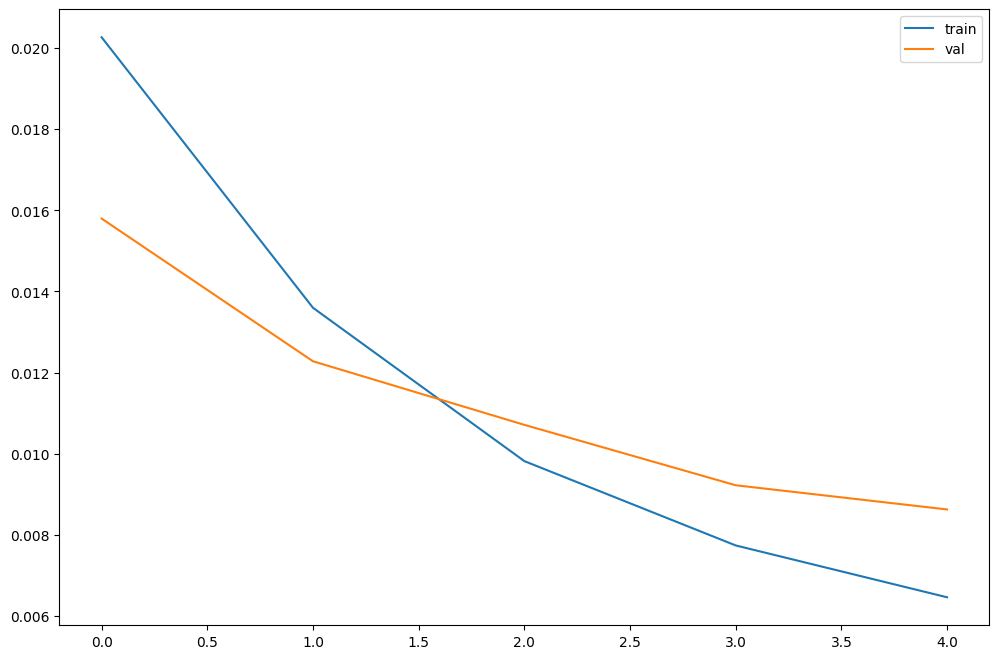

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses["train"], label="train")
plt.plot(losses["val"], label="val")
plt.legend()
plt.show()